   distance_from_home  distance_from_last_transaction  \
0           57.877857                        0.311140   
1           10.829943                        0.175592   
2            5.091079                        0.805153   
3            2.247564                        5.600044   
4           44.190936                        0.566486   

   ratio_to_median_purchase_price  repeat_retailer  used_chip  \
0                        1.945940              1.0        1.0   
1                        1.294219              1.0        0.0   
2                        0.427715              1.0        0.0   
3                        0.362663              1.0        1.0   
4                        2.222767              1.0        1.0   

   used_pin_number  online_order  fraud  
0              0.0           0.0    0.0  
1              0.0           0.0    0.0  
2              0.0           1.0    0.0  
3              0.0           1.0    0.0  
4              0.0           1.0    0.0  
<class 'pandas

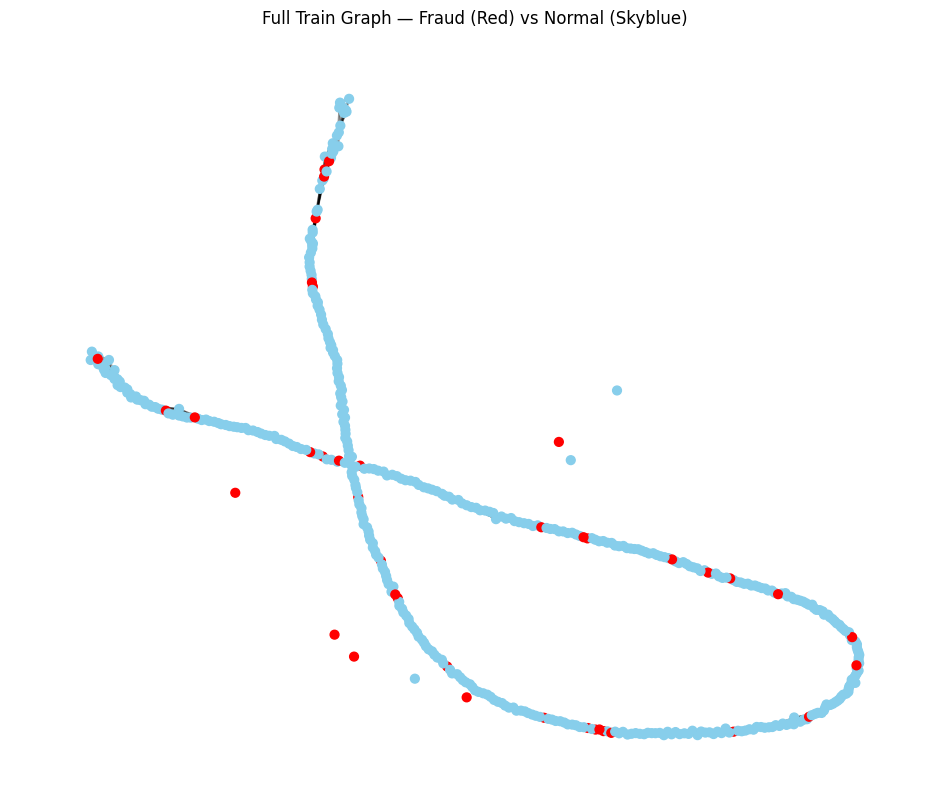

Visualizing 40 fraud nodes + 367 total nodes


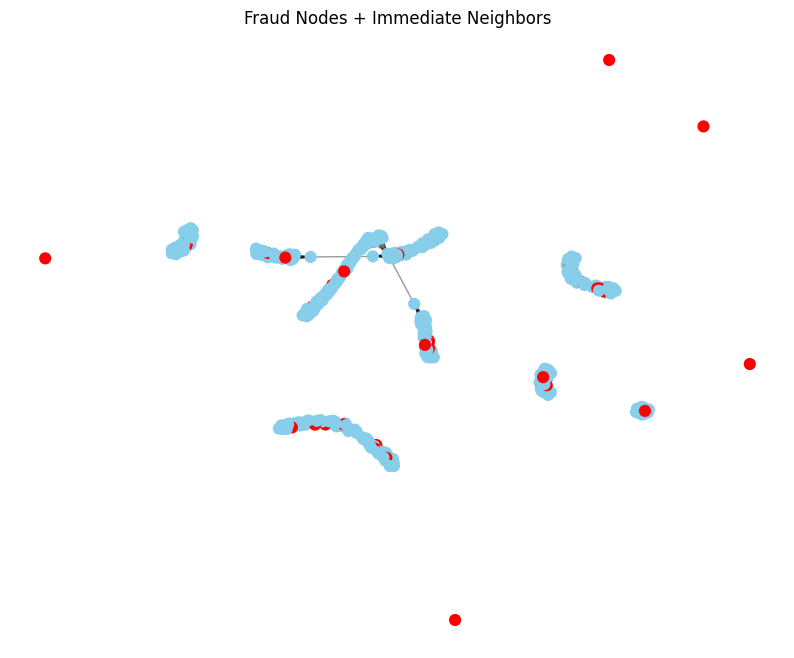

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Load dataset
df = pd.read_csv('card_transdata.csv')  # Replace with data from "https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud"

print(df.head())
print(df.info())
print(df['fraud'].value_counts())

from sklearn.model_selection import train_test_split

#   Cleaning boolean columns robustly
bool_cols = ['repeat_retailer', 'used_chip', 'used_pin_number', 'online_order']

# Best practice: map column by column — safe and warning-free
for col in bool_cols:
    df[col] = df[col].map({True: 1, False: 0})

#  Getting rid of NaNs
df['fraud'] = df['fraud'].fillna(0).astype(int)

# Selecting Features & target
X = df.drop('fraud', axis=1)
y = df['fraud']

# Combining our features & target (X and y)
df = X.copy()
df['fraud'] = y

#  Shuffling once for randomness
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

#  Manual 80/20 split(avoiding leakage)
split_idx = int(0.8 * len(df))
train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]

X_train = train_df.drop(columns=['fraud']).copy()
y_train = train_df['fraud']
X_test = test_df.drop(columns=['fraud']).copy()
y_test = test_df['fraud']

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

#  Removing the high-correlation feature
X_train_reduced = X_train.drop(columns=['ratio_to_median_purchase_price'])
X_test_reduced = X_test.drop(columns=['ratio_to_median_purchase_price'])

#  Building a small graph on TRAIN ONLY as training 100,000 records is consuming too much time
repeat_train = X_train[X_train['repeat_retailer'] == 1]

if repeat_train.shape[0] == 0:
    print("No repeat_retailer == 1 rows in train set. Skipping graph flagging.")
    repeat_train = pd.DataFrame(columns=X_train.columns)  # empty frame
    flagged_nodes = set()
else:
    repeat_train = repeat_train.sample(n=min(500, repeat_train.shape[0]), random_state=42)

    G = nx.Graph()
    G.add_nodes_from(repeat_train.index)

    # Adding edges if distance is close
    repeat_train_sorted = repeat_train.sort_values('distance_from_last_transaction')
    idxs = list(repeat_train_sorted.index)
    for i, idx1 in enumerate(idxs):
        row1 = repeat_train.loc[idx1]
        for j in range(i+1, min(i+10, len(idxs))):
            idx2 = idxs[j]
            row2 = repeat_train.loc[idx2]
            if abs(row1['distance_from_last_transaction'] - row2['distance_from_last_transaction']) < 5:
                G.add_edge(idx1, idx2)

    # Finding risky train nodes (cliques)
    flagged_nodes = set()
    for clique in nx.find_cliques(G):
        if len(clique) > 3:
            flagged_nodes.update(clique)

print(f"Flagged {len(flagged_nodes)} train nodes.")

# Adding graph_flag to train safely
X_train_reduced['graph_flag'] = X_train_reduced.index.isin(flagged_nodes).astype(int)


# Add graph_flag to test
def simple_graph_flag(row):
    return int(row['repeat_retailer'] == 1 and row['distance_from_last_transaction'] < 5)
X_test_reduced['graph_flag'] = X_test_reduced.apply(simple_graph_flag, axis=1)

print("Train graph_flag counts:\n", X_train_reduced['graph_flag'].value_counts())
print("Test graph_flag counts:\n", X_test_reduced['graph_flag'].value_counts())

#  Now we train Random Forest with balanced classes
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf.fit(X_train_reduced, y_train)

#  Predicting with tuned threshold
y_probs = clf.predict_proba(X_test_reduced)[:, 1]
y_pred_thresh = (y_probs > 0.3).astype(int)

print("\n FINAL CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_thresh))


repeat_train = X_train[X_train['repeat_retailer'] == 1]
if repeat_train.shape[0] == 0:
    print("No repeat_retailer==1 rows. Using random sample instead.")
    repeat_train = X_train.sample(n=min(500, X_train.shape[0]), random_state=42)
else:
    repeat_train = repeat_train.sample(n=min(500, repeat_train.shape[0]), random_state=42)

# Choosing a smarter threshold
threshold = repeat_train['distance_from_last_transaction'].std() * 0.5
print(f"Using edge threshold: {threshold:.2f}")

G = nx.Graph()
G.add_nodes_from(repeat_train.index)

repeat_train_sorted = repeat_train.sort_values('distance_from_last_transaction')
idxs = list(repeat_train_sorted.index)

for i, idx1 in enumerate(idxs):
    row1 = repeat_train.loc[idx1]
    for j in range(i+1, min(i+10, len(idxs))):
        idx2 = idxs[j]
        row2 = repeat_train.loc[idx2]
        if abs(row1['distance_from_last_transaction'] - row2['distance_from_last_transaction']) < threshold:
            G.add_edge(idx1, idx2)

print(f"Graph now has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")


import matplotlib.pyplot as plt
import networkx as nx

# Reusing TRAIN graph
# Or rebuild if needed
G = nx.Graph()
G.add_nodes_from(repeat_train.index)

repeat_train_sorted = repeat_train.sort_values('distance_from_last_transaction')
idxs = list(repeat_train_sorted.index)

for i, idx1 in enumerate(idxs):
    row1 = repeat_train.loc[idx1]
    for j in range(i+1, min(i+10, len(idxs))):
        idx2 = idxs[j]
        row2 = repeat_train.loc[idx2]
        if abs(row1['distance_from_last_transaction'] - row2['distance_from_last_transaction']) < 5:
            G.add_edge(idx1, idx2)

# Now we label fraud nodes in TRAIN
fraud_train_nodes = set(X_train.index[y_train == 1])

# Colors: red for fraud, skyblue for normal
node_colors = ['red' if node in fraud_train_nodes else 'skyblue' for node in G.nodes]

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, seed=42)  # Nice stable layout

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=40)
nx.draw_networkx_edges(G, pos, alpha=0.3)

plt.title('Full Train Graph — Fraud (Red) vs Normal (Skyblue)')
plt.axis('off')
plt.show()

# Picking fraud nodes present in the graph
fraud_in_graph = [n for n in G.nodes if n in fraud_train_nodes]

# Getting their next door neighbors
fraud_neighbors = set()
for n in fraud_in_graph:
    fraud_neighbors.update(G.neighbors(n))

# Building a subgraph
focus_nodes = set(fraud_in_graph) | fraud_neighbors
subG = G.subgraph(focus_nodes)

print(f"Visualizing {len(fraud_in_graph)} fraud nodes + {len(focus_nodes)} total nodes")

# Colors we assign
sub_colors = ['red' if n in fraud_in_graph else 'skyblue' for n in subG.nodes]

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(subG, seed=42)

nx.draw_networkx_nodes(subG, pos, node_color=sub_colors, node_size=60)
nx.draw_networkx_edges(subG, pos, alpha=0.4)

plt.title('Fraud Nodes + Immediate Neighbors')
plt.axis('off')
plt.show()